In [1]:
from model_utils import *
import librosa
import librosa.display
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow.keras as keras

np.random.seed(1337)
import tensorflow as tf
tf.random.set_seed(1337)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4936064457600307946
]


In [2]:
project_dir = r'D:/Sistemas de Informação/TCC/'
#project_dir = os.path.dirname(os.path.abspath(__file__))
data_dir = project_dir+'data/'
audioset_indices_csv = project_dir+'segments/subset_class_labels_indices.csv'
footstep_data = data_dir+'train/footstep_data'
other_data = data_dir+'train/other_data'

train_data = data_dir+'train/train_data'
train_csv = project_dir+ 'segments/2400_subset_unbalanced_train_segments.csv'

audioset_eval_csv = project_dir+'segments/subset_eval_segments.csv'
eval_sub_dir = 'eval/audio'

Load Data

In [49]:
# Load up numpy arrays to save time if they have already been procesed.

save_dir = footstep_data+"/features/"
feature_file = os.path.join(save_dir + '_x.npy')
labels_file = os.path.join(save_dir + '_y.npy')
train_x = np.load(feature_file)
train_y = np.load(labels_file)
print(train_x.shape)

(1243, 60, 420)


In [50]:
save_dir = other_data+"/features/"
feature_file = os.path.join(save_dir + '_x.npy')
labels_file = os.path.join(save_dir + '_y.npy')
train_xo = np.load(feature_file)
train_yo = np.load(labels_file)
print(train_xo.shape)

(1169, 60, 420)


In [51]:
train_x = np.append(train_x, train_xo, axis=0)
train_y = np.append(train_y, train_yo, axis=0)

In [12]:
train_y.dtype

dtype('int32')

In [13]:
train_y.shape

(2412,)

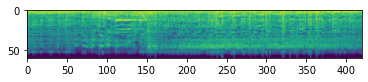

In [14]:
plt.imshow(train_x[0])

In [15]:
print(train_y[0])

1


In [6]:
from sklearn.utils import shuffle

# Shuffling features and labels arrays
train_x, train_y = shuffle(train_x, train_y)

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Splitting the dataset into train and test subsets

X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.10, random_state=42, stratify=train_y)
#X_train, X_test, Y_train, Y_test = StratifiedKFold(train_x, train_y, test_size=0.10, random_state=42, stratify=train_y)

(60, 420)


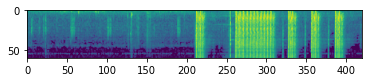

In [53]:
plt.imshow(X_train[0])
print(X_train[0].shape)

In [54]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2170, 60, 420)
(242, 60, 420)
(2170,)
(242,)


In [55]:
# Reshaping the data to fit the model

X_train = X_train.reshape(2170, 60, 420, 1)
X_test = X_test.reshape(242, 60, 420, 1)

In [21]:
#from keras.utils import to_categorical

#one-hot encode column
#Y_train = to_categorical(Y_train)
#Y_test = to_categorical(Y_test)

#Y_train[0]

array([1., 0.], dtype=float32)

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

# Personal note: have to observe and search the best fitting options for my model

# Creating the model
model = Sequential()

#Adding the model layers
model.add(Conv2D(filters=80, kernel_size=3, activation='relu', input_shape=
                (60, 420, 1)))
model.add(MaxPooling2D(pool_size=(4, 3), strides=(1, 3)))
#model.add(Dropout(0.75))
model.add(Conv2D(filters=80, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 3), strides=(1, 3)))
model.add(Conv2D(filters=80, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 3), strides=(1, 3)))
#model.add(Dropout(0.75))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [67]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 58, 418, 80)       800       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 55, 139, 80)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 55, 139, 80)       57680     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 52, 46, 80)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 52, 46, 80)        57680     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 49, 15, 80)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 58800)            

In [22]:
import visualkeras

visualkeras.layered_view(model, to_file='model.png').show() # write and show

In [129]:
#from keras.utils.vis_utils import plot_model
from plot_model import plot_model

# The problem: https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py
# Experiencing problems to install graphviz, it seems the releases in windows are not that supported.
# I should get back to this problem later, another solution is to plot the model by hand
# Don't forget this, it might be good to use it on the paper

# Model visualization 
plot_model(model, to_file=project_dir+'model.png', show_shapes=True, rankdir='TB')

ImportError: cannot import name 'network' from 'tensorflow.python.keras.engine' (D:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\__init__.py)

In [68]:
# Compiling the model
model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [73]:
# Trainning the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=128)

Epoch 1/10
17/17 [==============================] - 103s 6s/step - loss: 0.5811 - binary_accuracy: 0.7005 - val_loss: 0.5869 - val_binary_accuracy: 0.7107
Epoch 2/10
17/17 [==============================] - 99s 6s/step - loss: 0.5530 - binary_accuracy: 0.7189 - val_loss: 0.5987 - val_binary_accuracy: 0.7066
Epoch 3/10
17/17 [==============================] - 101s 6s/step - loss: 0.5439 - binary_accuracy: 0.7240 - val_loss: 0.6090 - val_binary_accuracy: 0.7025
Epoch 4/10
17/17 [==============================] - 98s 6s/step - loss: 0.5404 - binary_accuracy: 0.7194 - val_loss: 0.5787 - val_binary_accuracy: 0.7231
Epoch 5/10
17/17 [==============================] - 99s 6s/step - loss: 0.5388 - binary_accuracy: 0.7332 - val_loss: 0.6062 - val_binary_accuracy: 0.6901
Epoch 6/10
17/17 [==============================] - 99s 6s/step - loss: 0.5069 - binary_accuracy: 0.7419 - val_loss: 0.5783 - val_binary_accuracy: 0.7066
Epoch 7/10
17/17 [==============================] - 100s 6s/step - loss: 0

In [77]:
# Predicting the the sounds with the test sets
model.predict(X_test[:20])

array([[5.13458252e-02],
       [6.42836094e-04],
       [3.93387914e-01],
       [4.30468917e-01],
       [4.67463732e-02],
       [9.88540053e-03],
       [5.23550808e-01],
       [5.99532306e-01],
       [1.53818339e-01],
       [7.42701086e-05],
       [2.29609549e-01],
       [4.66762066e-01],
       [7.82689452e-03],
       [1.24939024e-01],
       [1.73337340e-01],
       [2.51690567e-01],
       [4.55202281e-01],
       [6.25813723e-01],
       [3.41035068e-01],
       [3.75051290e-01]], dtype=float32)

In [75]:
# Test results comparison
Y_test[:20]

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0])

8/8 - 2s - loss: 0.7309 - binary_accuracy: 0.6240


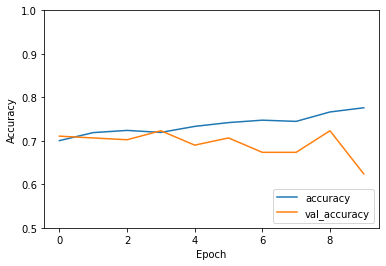

In [76]:
# Evaluation plot

plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)

In [47]:
print(test_acc)

0.5165289044380188


In [78]:
 # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')

In [79]:
for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d_18 (3, 3, 1, 80)
conv2d_19 (3, 3, 80, 80)
conv2d_20 (3, 3, 80, 80)


In [21]:
# retrieve weights from the second hidden layer
#filters , bias = model.layers[1].get_weights()

ValueError: not enough values to unpack (expected 2, got 0)

In [80]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

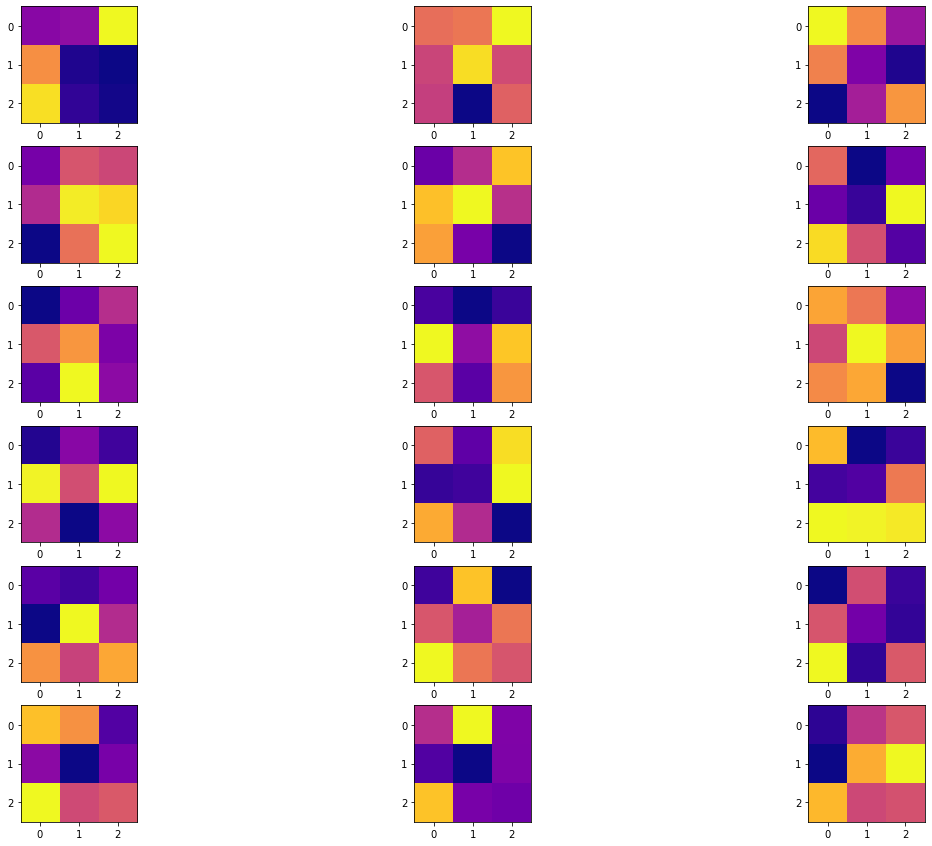

In [84]:
n_filters =6
ix=1
fig = pyplot.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        pyplot.subplot(n_filters,3,ix)
        pyplot.imshow(f[:,:,j] ,cmap='plasma')
        ix+=1
#plot the filters 
pyplot.show()